In [1]:
# from numba import cuda
from keras import backend as K

from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras
from keras.callbacks import TensorBoard

from sklearn import preprocessing

from copy import deepcopy
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
style.use('ggplot')
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
conn = MongoClient('120.126.136.17')
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))
df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)

df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

# map out the weekday
df['weekday'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%w'))
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).isocalendar()[1]
          - (datetime.datetime.fromtimestamp(x).isoweekday() < 7)) # do this so that week may start on monday

In [4]:
dfstephour = pd.DataFrame({})
dfstephour = df[['week', 'weekday']].set_index(['week', 'weekday'])
dfstephour = dfstephour[~dfstephour.index.duplicated(keep='first')]
dfstephour.reset_index(inplace=True)
# this is where the data have null
dfadd = pd.DataFrame({'week' : [12], 'weekday':['5']})
dfstephour = dfstephour.append(dfadd, ignore_index=True)
dfadd = pd.DataFrame({'week' : [12], 'weekday':['2']})
dfstephour = dfstephour.append(dfadd, ignore_index=True)
dfadd = pd.DataFrame({'week' : [12], 'weekday':['1']})
dfstephour = dfstephour.append(dfadd, ignore_index=True)
dfadd = pd.DataFrame({'week' : [12], 'weekday':['0']})
dfstephour = dfstephour.append(dfadd, ignore_index=True)
dfstephour = dfstephour.set_index(['week', 'weekday'])
dfstephour.sort_index(inplace=True)
for i in range(24):
    dfstephour[i] = 0

In [5]:
# here I map between integer and the sting it's mean
timeslidemap = {0:'msteps', 1:'asteps', 2:'esteps'}
basestamp = df['timestamp'][0]
endstamp = df['timestamp'][-1:].values[0]
# for num, row in df[:30000].iterrows():
while True:
    try:
        hour = datetime.datetime.fromtimestamp(basestamp).hour
        dfbetween = df.loc[df['timestamp'].between(
            datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=0,second=0).timestamp(),
            datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=59,second=59).timestamp()
                    , inclusive=True)]
        steps = dfbetween['step_value'].sum()
    #     print(int(datetime.datetime.fromtimestamp(basestamp).strftime('%m')),
    #             int(datetime.datetime.fromtimestamp(basestamp).strftime('%d')),
    #                 timeslidemap[estimedevide])
    
        dfstephour.loc[[(datetime.datetime.fromtimestamp(basestamp).isocalendar()[1] - 
                                    (datetime.datetime.fromtimestamp(basestamp).isoweekday() < 7),
                            datetime.datetime.fromtimestamp(basestamp).strftime('%w'))], 
                                           [hour]] += steps

        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
        if basestamp > endstamp:
            break
    except Exception as e:
#         print(str(e))
        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
#     else:
#         print(datetime.datetime.fromtimestamp(basestamp) ,datetime.datetime.fromtimestamp(endstamp))

In [115]:
dfstephour.loc[(13,)]

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0,0.0,33.0,...,0.0,24.0,0.0,243.0,95.0,0.0,29.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004.0,2347.0,...,894.0,0.0,130.0,0.0,402.0,84.0,377.0,1260.0,22.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,248.0,133.0,1036.0,...,1320.0,50.0,1413.0,339.0,0.0,1066.0,16.0,0.0,0.0,23.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.0,1018.0,...,0.0,0.0,688.0,920.0,53.0,0.0,2107.0,78.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,216.0,283.0,22.0,176.0,...,1520.0,596.0,57.0,89.0,76.0,1668.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,318.0,318.0,0.0,...,34.0,24.0,0.0,1471.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,28.0,...,25.0,27.0,1622.0,0.0,1302.0,24.0,27.0,0.0,0.0,0.0


In [132]:
dfstephour.loc[[(13,'1'),[15,'1']]]

,,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
week,weekday,,,,,,,,,,,,,,,,,,,,,
13,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004.0,2347.0,...,894.0,0.0,130.0,0.0,402.0,84.0,377.0,1260.0,22.0,0.0
15,1,0.0,0.0,0.0,0.0,0.0,0.0,1011.0,100.0,1935.0,3030.0,...,0.0,598.0,764.0,492.0,153.0,1717.0,430.0,56.0,0.0,42.0


<IPython.core.display.Javascript object>


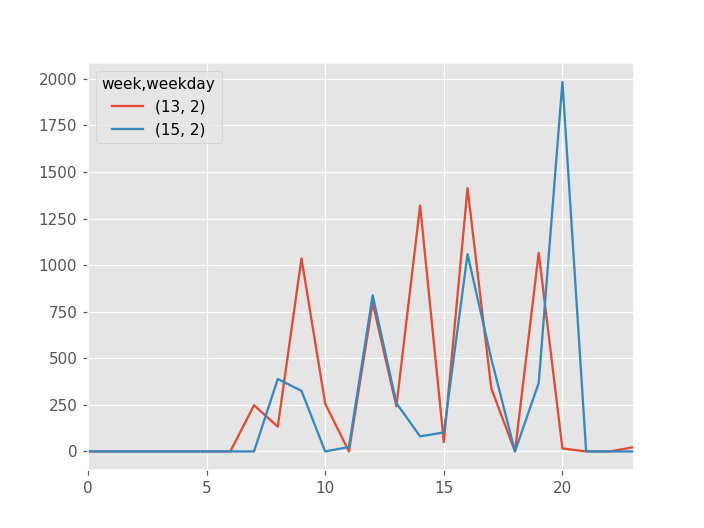

In [135]:
%matplotlib notebook
dfstephour.loc[[(13,'2'),[15,'2']]].T.plot()

In [ ]:
%matplotlib notebook
dfstephour.loc[[(13,'2'),[15,'2']]].T.plot()

In [1]:
# split a multivariate sequence into samples
def split_sequences_hour(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
#         print(end_ix)
        #check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix]#.reshape(len(sequences[i:end_ix]),1) 
#         print(seq_x)
#         break
#         seq_x = np.append(seq_x, sequences[1][i:end_ix].reshape(len(sequences[1][i:end_ix]),1), axis=1)
#         seq_x = np.append(seq_x, sequences[2][i:end_ix].reshape(len(sequences[2][i:end_ix]),1), axis=1)
        seq_y = sequences[end_ix][-1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
steps = dfstephour.values
train_X = []
for weekday,i in enumerate(steps):
    for hour,j in enumerate(i):
        add = np.array([j])#[weekday, hour, j]
        train_X.append(add)
train_X = np.array(train_X)
# normalized_X = preprocessing.scale(train_X)
# normalized_Y = preprocessing.normalize()
# normalstack_X = np.hstack(normalized_X)
# normalized_Y = preprocessing.normalize([Comfort])
# normalized_Z = preprocessing.normalize([Precp])
# dataset = np.array([normalized_X[0],normalized_Y[0],normalized_Z[0]])
n_steps = 7
X, y = split_sequences(train_X, n_steps)
# for i in range(70,100):
#     print(train_X[i])
#     print(X[i], y[i])

In [8]:
n_features = 1
model = Sequential()
model.add(keras.layers.LSTM(100,activation='relu', return_sequences=True,input_shape=(n_steps, n_features),dropout=0.1))
model.add(keras.layers.LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 100)            40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [12]:
callbacks = [
    keras.callbacks.TensorBoard(
        log_dir='log',
        histogram_freq=1,
    )
]

In [13]:
history = model.fit(X, y, epochs=100, verbose=0, batch_size=128, validation_split=0.2,callbacks=callbacks)

In [23]:
del model

<IPython.core.display.Javascript object>


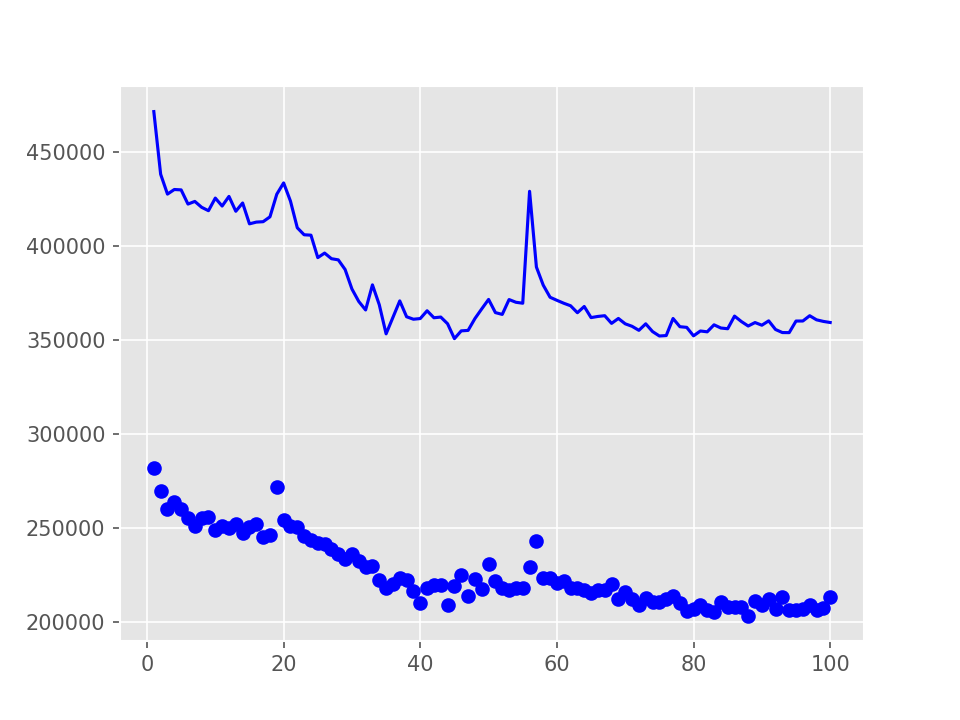

In [14]:
%matplotlib notebook
loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()

In [14]:
model.predict(np.array([X[-3]]))

array([[155.45935]], dtype=float32)

In [15]:
del model

In [17]:
K.clear_session()

In [20]:
n_features = 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50 ,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 6, 64)             192       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                9650      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 9,893
Trainable params: 9,893
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X, y, epochs=150, verbose=0, batch_size=128, validation_split=0.2)

<IPython.core.display.Javascript object>


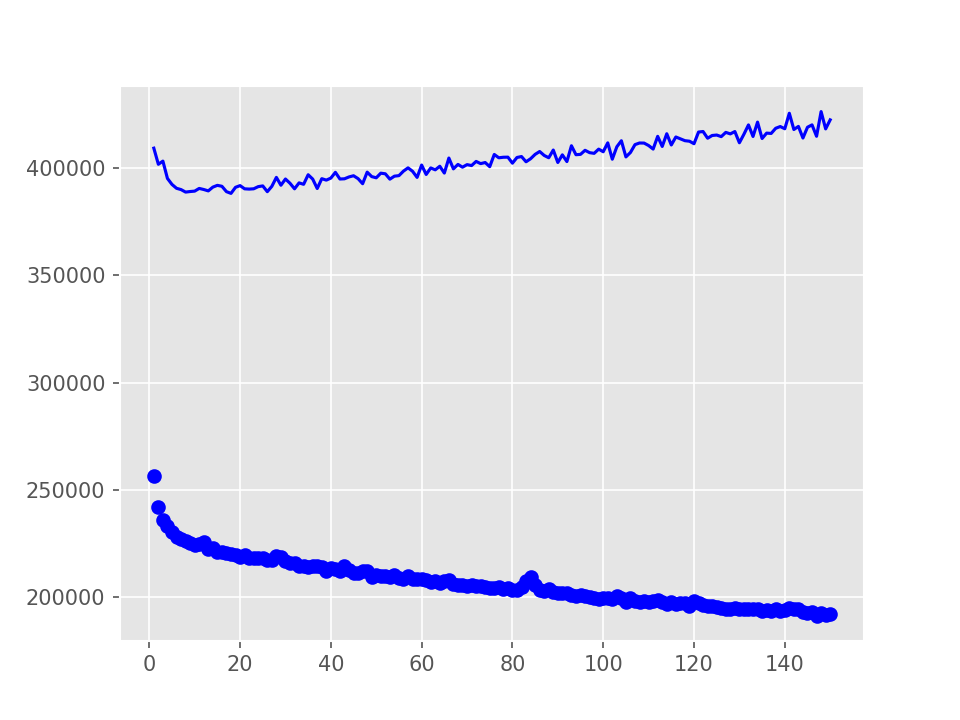

In [22]:
%matplotlib notebook
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()

In [9]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
       # find the end of this pattern
        end_ix = i + n_steps
#         print(end_ix)
        #check if we are beyond the dataset
        if end_ix + 2 > len(sequences) - 1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix].reshape(len(sequences[i:end_ix]),1) 
#         print(seq_x)
#         break
#         seq_x = np.append(seq_x, sequences[i + 1:end_ix + 1])
#         seq_x = np.append(seq_x, sequences[i + 2:end_ix + 2])
        seq_y = sequences[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [51]:
steps = dfstephour.values
train_X = []
# for weekday,i in enumerate(steps):
#     for hour,j in enumerate(i):
#         add = np.array([weekday, hour, j])
#         train_X.append(add)
train_X = np.hstack(steps)
# normalized_X = preprocessing.scale(train_X)
# normalized_Y = preprocessing.normalize()
# normalstack_X = np.hstack(normalized_X)
# normalized_Y = preprocessing.normalize([Comfort])
# normalized_Z = preprocessing.normalize([Precp])
# dataset = np.array([normalized_X[0],normalized_Y[0],normalized_Z[0]])
n_steps = 7
X, y = split_sequences(train_X, n_steps)
# for i in range(30,100):
#     print(X[i], y[i])

In [52]:
n_features = 1
model = Sequential()
model.add(keras.layers.LSTM(100,activation='relu', return_sequences=True,input_shape=(n_steps, n_features), dropout=0.2))
model.add(keras.layers.LSTM(30, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 7, 100)            40800     
_________________________________________________________________
lstm_14 (LSTM)               (None, 30)                15720     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 56,551
Trainable params: 56,551
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model.fit(X, y, epochs=500, verbose=0, batch_size=128, validation_split=0.2)

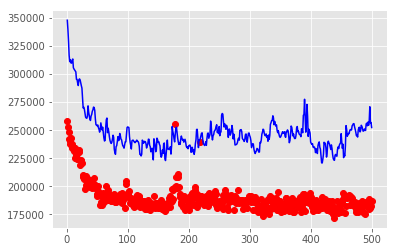

In [54]:
# step = 7
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'ro')
plt.plot(epochs, val_loss, 'b')
plt.show()

In [27]:
model.predict(X[-50:-])

array([[447.51093]], dtype=float32)